In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from glob import glob

In [3]:
df = pd.DataFrame()
for f in glob('datasets/*.csv'):
    df = pd.concat([
        df,
        pd.read_csv(f)
    ], ignore_index=True)
df['pseudchartTime'] = pd.to_datetime(df['pseudchartTime'], format="%d/%m/%Y %H:%M")

In [4]:
columns = [
    "pO2 kPa (ABL)",
    "pCO2 kPA (ABL)",
    "Na+ mmol/L (ABL)",
    "Ca++ mmol/L (ABL)",
    "Cl- mmol/L (ABL)",
    "Lactate mmol/L (ABL)",
    "Albumin",
    "Urea",
    "Phosphate",
    "pH (ABL)",
]
sample = df.query('longLabel in @columns')
sample = sample.pivot_table(
    index=['alias', 'pseudchartTime'],
    columns='longLabel',
    values='valueNumber'
).reset_index()
sample["alias"] = sample["alias"].str.split("-").str[1].apply(lambda x: f"G-{int(x):02}")

In [5]:
data = sample.copy()
data = data.rename(
    {
        'pCO2 kPA (ABL)': 'pco2',
        'pO2 kPa (ABL)': 'po2',
        'Na+ mmol/L (ABL)': 'na',
        'Cl- mmol/L (ABL)': 'cl',
        'Ca++ mmol/L (ABL)': 'ca',
        'Albumin': 'albumin',
        'Lactate mmol/L (ABL)': 'lactate',
        'Urea': 'urea',
        'Phosphate': 'phosphate',
        'pH (ABL)': 'ph',
    },
    axis=1
)

data = data.sort_values(['alias', 'pseudchartTime'])
data['sid'] = data['na'] + data['ca'] - data['cl']
data_gap = data.copy()

# ffill albumin
for col in ['albumin', 'phosphate', 'urea']:
    data[col] = data.groupby('alias')[col].ffill()
    data[col] = data.groupby('alias')[col].bfill()

# data = data.dropna()

# Interpolation

In [6]:
from interpolations import *

agg_patient = data_gap.groupby(['alias', pd.Grouper(key='pseudchartTime', freq='1h')]).mean(numeric_only=True).reset_index().copy()
agg_patient['unix_timestamp'] = agg_patient['pseudchartTime'].astype(int) / 1e9 / 3600

def get_patient(agg_patient, alias, admission=None):
    patient = agg_patient.query('alias == @alias')
    if admission is not None:
        patient = patient.query('admission == @admission')
    patient = patient.set_index('pseudchartTime').resample('1h').mean(numeric_only=True).reset_index().copy()
    patient['unix_timestamp'] = patient['pseudchartTime'].astype(int) / 1e9 / 3600
    return patient

In [7]:
from sklearn.cluster import DBSCAN

mdl = DBSCAN(eps=24*7)
agg_patient['admission'] = mdl.fit_predict(agg_patient[['unix_timestamp']])
agg_patient['window'] = agg_patient.apply(lambda x: f"{x.alias} + {x.admission}", axis=1)

In [8]:
agg_patient.groupby(['alias', 'admission']).size()

alias  admission
G-01    0            55
G-02    1            41
G-03   -1             7
        2            43
G-04    3            17
G-05    3            67
G-06    4            56
G-07    5            54
G-08    6             9
G-09    7            23
G-10    8           124
        9            84
G-11    10           13
G-12   -1             4
        11           49
        12           30
        13           23
G-13    14           74
G-14    15           69
dtype: int64

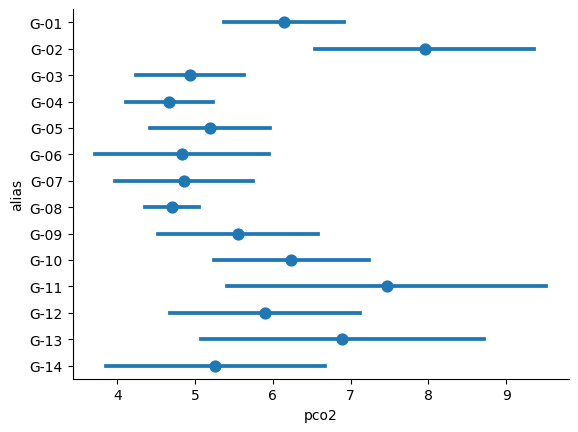

In [9]:
sns.pointplot(
    x='pco2',
    y='alias',
    errorbar='sd',
    linestyle='none',
    data=agg_patient,
)
sns.despine()

# DGPSI

In [28]:
from sklearn.preprocessing import StandardScaler

window = "G-10 + 8"
features = [
    "pco2",
    "sid",
    "lactate",
]

alias, admission = window.split(" + ")
admission = int(admission)

patient_per_hour = get_patient(agg_patient, alias, admission)
patient_df = patient_per_hour.dropna(subset="ph").copy()
# patient_df['all_na'] = np.nan

y_scaler = StandardScaler()
Y = y_scaler.fit_transform(patient_df[["ph"]].values)

X = patient_df[["unix_timestamp"]].values
X = (X - X.min()) / (X.max() - X.min())

scaler = StandardScaler()
H = scaler.fit_transform(patient_df[features].values)

In [29]:
import dgpsi as dgp

class DGP:
    def __init__(self, features, n_iter=300):
        self.features = features
        self.n_iter = n_iter

    def fit(self, X, H, Y):
        layer1 = [
            dgp.kernel(
                length=np.array([.1]),
                name='sexp',
                scale_est=False,
                nugget_est=False,
                nugget=1e-3,
            )
            for _ in range(len(self.features))
        ]
        layer2 = [
            dgp.kernel(
                length=np.array([.1]),
                name='sexp',
                scale_est=False,
                nugget_est=False,
                nugget=1e-3,
                connect=np.arange(1),
            )
        ]
        all_layers = dgp.combine(layer1, layer2)

        # Using observed latent variables
        self.m = dgp.dgp(X, [H, Y], all_layers)
        self.m.train(N=self.n_iter, disable=True)

        return self

    def predict(self, X, full_layer=False):
        final_layer_obj = self.m.estimate()
        emu = dgp.emulator(final_layer_obj)
        mu, var = emu.predict(X, method='mean_var', full_layer=full_layer)
        return mu, var

class GP:
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        self.model = dgp.gp(
            X, Y,
            dgp.kernel(
                length=np.array([1.]),
                name='sexp',
                scale_est=False,
                nugget_est=False,
                nugget=1e-3,
            )
        )
        self.model.train()
    
    def predict(self, X):
        mu, var = self.model.predict(X)
        return mu, var

In [31]:
# model = DGP(features=features, n_iter=100)
# model.fit(X, H, Y)

# z = np.linspace(0, 1, 300)[:, None].reshape(-1, 1)
# ml, vl = model.predict(z, full_layer=True)
# lbl = (ml[1] - 2 * np.sqrt(vl[1])).flatten()
# ubl = (ml[1] + 2 * np.sqrt(vl[1])).flatten()

# fig, ax = plt.subplots(figsize=(15, 5))
# plt.plot(z.flatten(), ml[1].flatten())
# plt.fill_between(z.flatten(), lbl, ubl, alpha=0.3)
# plt.scatter(X, Y)
# plt.axhline(y_scaler.transform([[7.4]]), linestyle="--", linewidth=0.8, c="k")
# plt.ylim(-4, 4);

In [19]:
def ampute(df, label_columns, p_missing):
    X = df.copy()
    n_missing_samples = int(p_missing * X.shape[0])
    for label_column in label_columns:
        indices = np.random.choice(X.index, n_missing_samples, replace=False)
        X.loc[indices, label_column] = np.nan
    return X

In [20]:
windows = agg_patient.dropna(subset="ph").groupby('window').size()
windows[windows.ge(windows.quantile(.25))]

window
G-01 + 0      53
G-02 + 1      39
G-03 + 2      36
G-05 + 3      59
G-06 + 4      51
G-07 + 5      53
G-09 + 7      20
G-10 + 8     115
G-10 + 9      78
G-12 + 11     40
G-12 + 12     28
G-12 + 13     19
G-13 + 14     65
G-14 + 15     64
dtype: int64

In [21]:
# np.random.seed(10)

# features = ["pco2", "sid", "lactate"]
# maes = []
# windows = agg_patient.dropna(subset="ph").groupby("window").size()
# windows = windows[windows.gt(windows.quantile(0.25))].index

# for p_missing in np.arange(0.1, 0.5, 0.1):
#     for window in windows:
#         alias, admission = window.split(" + ")
#         admission = int(admission)

#         patient_per_hour = get_patient(agg_patient, alias, admission)
#         patient_df = patient_per_hour.dropna(subset="ph").copy()

#         for i in range(10):
#             amputed_df = ampute(
#                 patient_df[["unix_timestamp"] + features + ["ph"]],
#                 features,
#                 p_missing=p_missing,
#             )
#             amputed_df.to_csv(f"experiments/features/{p_missing:.1f}_{window}_{i}_masked.csv", index=False)
#         patient_df.to_csv(f"experiments/features/{p_missing:.1f}_{window}_0_filled.csv", index=False)

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

np.random.seed(10)

features = ["pco2", "sid", "lactate"]
maes = []
windows = agg_patient.dropna(subset="ph").groupby("window").size()
windows = windows[windows.gt(windows.quantile(0.25))].index

for p_missing in tqdm(np.arange(0.1, 0.5, 0.1)):
    for window in windows:
        patient_df = pd.read_csv(f"experiments/ph/{p_missing:.1f}_{window}_0_filled_ph.csv")

        for i in range(10):
            amputed_df = pd.read_csv(f"experiments/ph/{p_missing:.1f}_{window}_{i}_masked_ph.csv")

            patient_df["ph_nan"] = amputed_df["ph"]
            amputed_df = amputed_df.dropna(subset="ph")

            y_scaler = StandardScaler()
            Y = y_scaler.fit_transform(amputed_df[["ph"]].values)

            minmaxscaler = MinMaxScaler()
            X = minmaxscaler.fit_transform(amputed_df[["unix_timestamp"]].values)

            X_pred = minmaxscaler.transform(patient_df[["unix_timestamp"]].values)

            scaler = StandardScaler()
            H = scaler.fit_transform(amputed_df[features].values)

            try:
                # DGP
                model = DGP(features, n_iter=100)
                model.fit(X, H, Y)
                mu, var = model.predict(X_pred, full_layer=True)
                lb = y_scaler.inverse_transform((mu[1] - 2 * np.sqrt(var[1]))).flatten()
                ub = y_scaler.inverse_transform((mu[1] + 2 * np.sqrt(var[1]))).flatten()

                patient_df["ph_dgp"] = y_scaler.inverse_transform(mu[1]).flatten()
                patient_df["ph_lb"] = lb
                patient_df["ph_ub"] = ub

                # MICE
                # imputer = Imputers().get("mice")
                # patient_df["ph_mice"] = imputer.fit_transform(
                #     patient_df[features + ["ph_nan"]]
                # ).values[:, -1]
                patient_df["ph_ffill"] = patient_df["ph_nan"].ffill().bfill()

                # GP by DGP-SI
                model = GP()
                model.fit(X, Y)
                mu, var = model.predict(X_pred)
                patient_df["ph_gp"] = y_scaler.inverse_transform(mu.reshape(-1, 1))

                # Filtering masked values
                masked_df = patient_df[patient_df["ph_nan"].isna()]

                maes.append(
                    {
                        "window": window,
                        "iter": i,
                        "n": patient_df.shape[0],
                        "p_missing": p_missing,
                        "mae gp": mean_absolute_error(
                            masked_df["ph"], masked_df["ph_gp"]
                        ),
                        "mae dgp": mean_absolute_error(
                            masked_df["ph"], masked_df["ph_dgp"]
                        ),
                        # "mae mice": mean_absolute_error(
                        #     masked_df["ph"], masked_df["ph_mice"]
                        # ),
                        "mae ffill": mean_absolute_error(
                            masked_df["ph"], masked_df["ph_ffill"]
                        ),
                    }
                )
            except:
                print(f"Failed in {p_missing:.1f}_{window}_{i}")

 50%|█████     | 2/4 [18:57<17:15, 517.51s/it]/Users/ali.septiandri/miniforge3/envs/phd/lib/python3.9/site-packages/dgpsi/kernel_class.py:137: RuntimeWarning: overflow encountered in exp
  theta=np.exp(log_theta)
/Users/ali.septiandri/miniforge3/envs/phd/lib/python3.9/site-packages/dgpsi/kernel_class.py:101: RuntimeWarning: invalid value encountered in subtract
  self.g=lambda x: (self.prior_coef[0]-1)*np.log(x)-self.prior_coef[1]*x


Failed in 0.3_G-01 + 0_2


100%|██████████| 4/4 [24:15<00:00, 363.96s/it]


In [24]:
pd.DataFrame(maes).to_parquet('results/20241107/ph-dgp.parquet')